In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt

In [3]:
img = io.read_image('../puppy.jpg')
print(img.shape)

torch.Size([3, 1330, 1920])


In [3]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape) == 3: x = x.permute(1, 2, 0)
    plt.imshow(x.cpu(), **kwargs)

In [4]:
img2 = tvf.resize(img, 150, antialias=True)
ch, h, w = img2.shape
ch, h, w, h*w

(3, 150, 216, 32400)

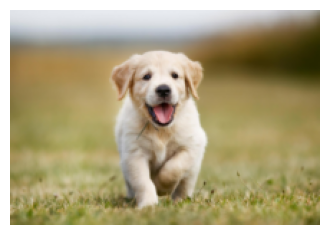

In [5]:
show_img(img2)

### Basic Python

In [6]:
def rgb2gray_py(img):
    c, h, w = img.shape
    n = h * w
    x = img.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+(2*n)]
    return res.view(h, w)

In [7]:
%%time
img_g = rgb2gray_py(img2)

CPU times: total: 875 ms
Wall time: 1.19 s


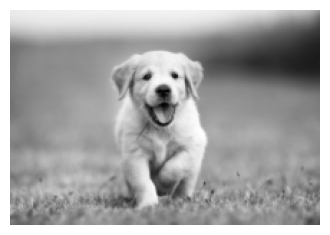

In [8]:
show_img(img_g, cmap='gray')

### Python Kernel

In [9]:
def run_kernel(kernel_func, times, *args):
    for i in range(times): kernel_func(i, *args)

In [10]:
def rgb2gray_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+(2*n)] 

In [11]:
def rgb2gray_pyk(img):
    c, h, w = img.shape
    n = h*w
    x = img.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2gray_k, n, x, res, n)
    return res.view(h, w)

In [12]:
%%time
img_g = rgb2gray_pyk(img2)

CPU times: total: 734 ms
Wall time: 1.26 s


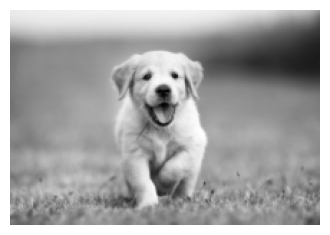

In [13]:
show_img(img_g, cmap='gray')

### Python Block Kernel

- Streaming Multiprocessors (SMs): In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.

- Thread Blocks: A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.

- Shared Memory: Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.

- The RTX 3090, based on the Ampere architecture, has 82 SMs.

- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory

- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [14]:
def run_block_kernel(block_kernel_func, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): block_kernel_func(i, j, threads, *args) 

In [15]:
def rgb2gray_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i < n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+(2*n)]

In [16]:
def rgb2gray_pybk(img):
    c, h, w = img.shape
    n = h*w
    x = img.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(n/threads))
    run_block_kernel(rgb2gray_bk, blocks, threads, x, res, n)
    return res.view(h, w)

In [17]:
%%time
img_g = rgb2gray_pybk(img2)

CPU times: total: 922 ms
Wall time: 1.2 s


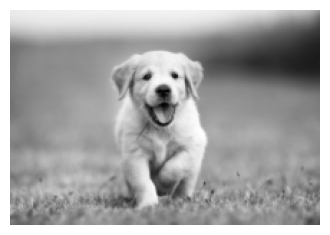

In [18]:
show_img(img_g, cmap='gray')

### CUDA implementation in cuda files